In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt

In [12]:
date_rng = pd.date_range(start='2018-01-01', periods=60, freq='M')
np.random.seed(42)
seasonal_pattern = 10 * np.sin(2 * np.pi * date_rng.month / 12)
trend = np.linspace(0, 50, 60)  
noise = np.random.randn(60) * 2  
data = seasonal_pattern + trend + noise

/var/folders/9r/1ltc4wfd3bb4rgvhr9km48v80000gn/T/ipykernel_61876/2795400262.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2018-01-01', periods=60, freq='M')


In [16]:
df = pd.DataFrame(data=data, index = date_rng, columns = ['Value'])

In [22]:
df.head()

,Value
2018-01-31,5.993428
2018-02-28,9.231183
2018-03-31,12.990292
2018-04-30,14.248687
2018-05-31,7.921524


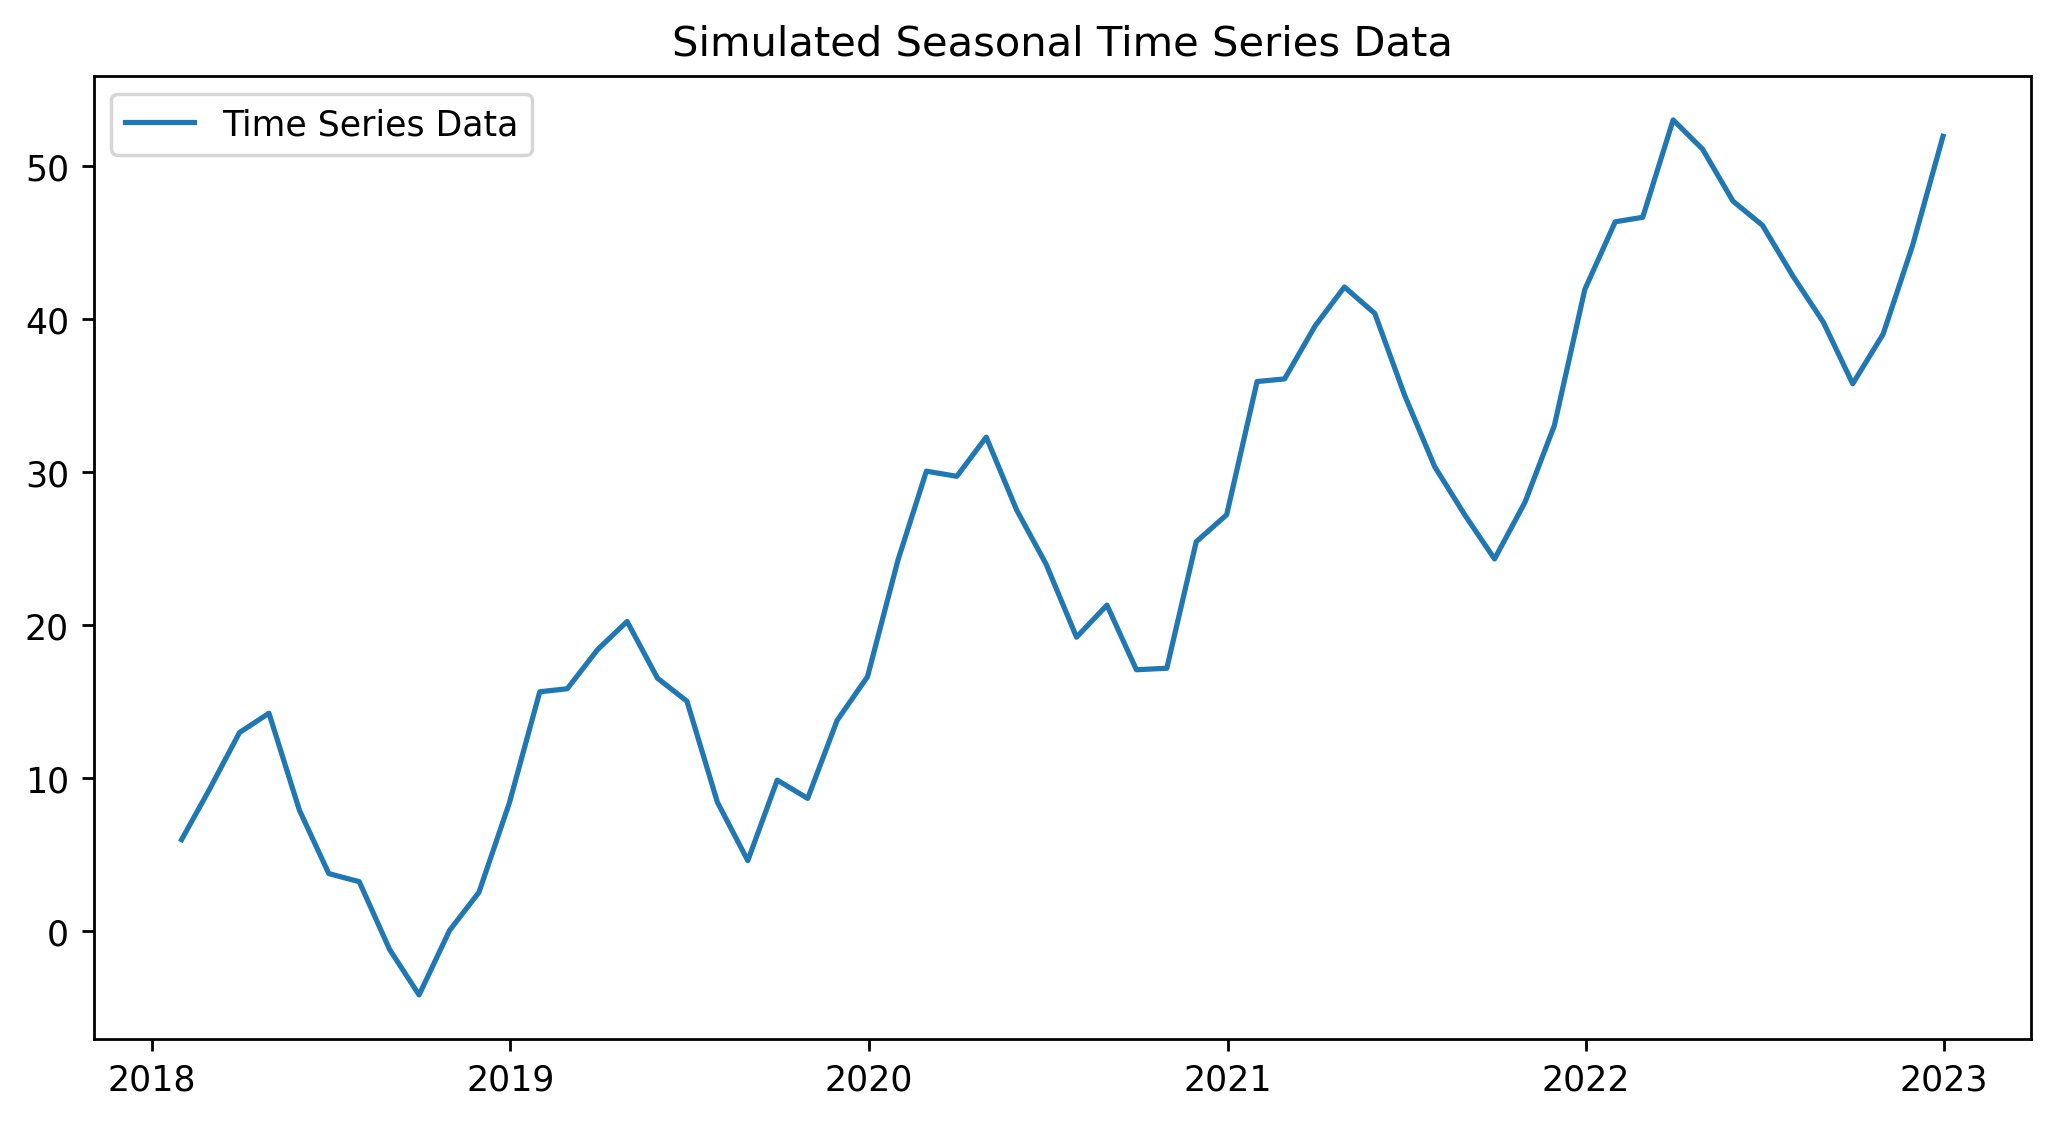

In [36]:
plt.figure(figsize = (10,5),dpi = 250)
plt.plot(df, label='Time Series Data')
plt.title("Simulated Seasonal Time Series Data")
plt.legend()
plt.show()

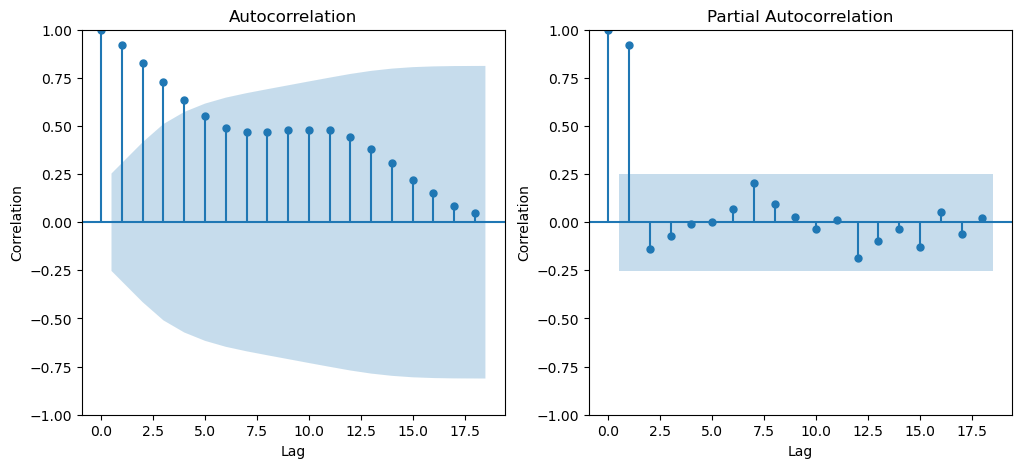

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Value'], ax=axes[0])
axes[0].set_title("Autocorrelation")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Correlation")
plot_pacf(df['Value'], ax=axes[1])
axes[1].set_title("Partial Autocorrelation")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Correlation")

plt.show()

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [48]:
p, d, q = 1, 1, 1 
P, D, Q, s = 1, 1, 1, 12 

In [50]:
sarima_model = SARIMAX(df['Value'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fitted = sarima_model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85875D+00    |proj g|=  1.41011D-01

At iterate    5    f=  1.76727D+00    |proj g|=  2.78784D-02

At iterate   10    f=  1.76125D+00    |proj g|=  1.03091D-02

At iterate   15    f=  1.76057D+00    |proj g|=  9.55608D-04

At iterate   20    f=  1.76050D+00    |proj g|=  2.52630D-03

At iterate   25    f=  1.76048D+00    |proj g|=  3.73369D-04

At iterate   30    f=  1.76048D+00    |proj g|=  1.26784D-04

At iterate   35    f=  1.76047D+00    |proj g|=  1.06190D-04

At iterate   40    f=  1.76047D+00    |proj g|=  3.97888D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [55]:
forecast_steps = 12
sarima_forecast = sarima_fitted.forecast(steps=forecast_steps)

/var/folders/9r/1ltc4wfd3bb4rgvhr9km48v80000gn/T/ipykernel_61876/1187083486.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:],


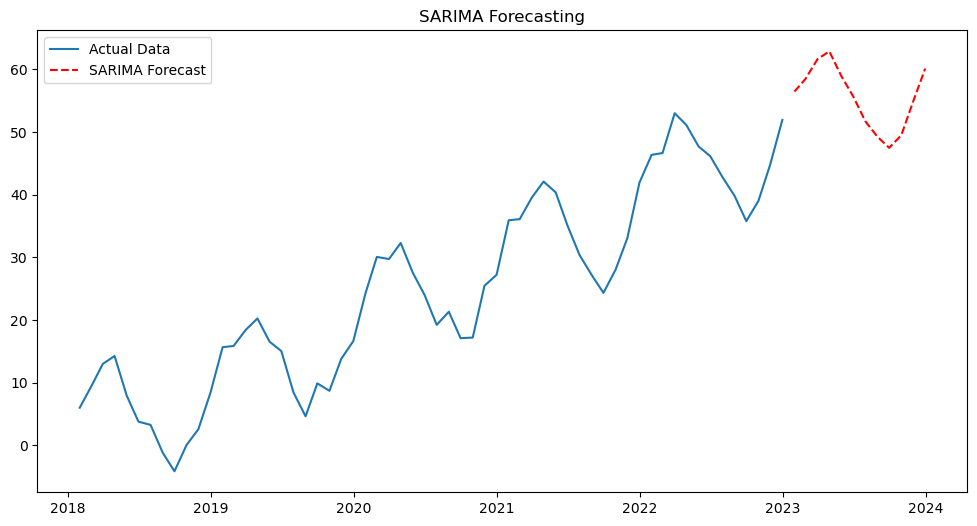

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(df, label='Actual Data')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:], 
         sarima_forecast, label='SARIMA Forecast', linestyle = 'dashed', color='red')
plt.title("SARIMA Forecasting")
plt.legend()
plt.show()

In [63]:
from sklearn.preprocessing import MinMaxScaler

In [65]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Value']])

In [67]:
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [69]:
sequence_length = 12
X, y = create_sequences(scaled_data, sequence_length)

In [71]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [73]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
model.compile(optimizer='adam', loss='mse')

In [107]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0034 - val_loss: 0.0153
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0103
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - val_loss: 0.0167
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.0098
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0069
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_lo

In [109]:
lstm_predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [111]:
lstm_predictions = scaler.inverse_transform(lstm_predictions)

In [113]:
lstm_forecast_index = pd.date_range(start=df.index[-len(lstm_predictions)], 
                                    periods=len(lstm_predictions), freq='M')

/var/folders/9r/1ltc4wfd3bb4rgvhr9km48v80000gn/T/ipykernel_61876/948795965.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  lstm_forecast_index = pd.date_range(start=df.index[-len(lstm_predictions)],


In [115]:
lstm_forecast_df = pd.DataFrame(lstm_predictions,
                                index=lstm_forecast_index, 
                                columns=['LSTM Forecast'])

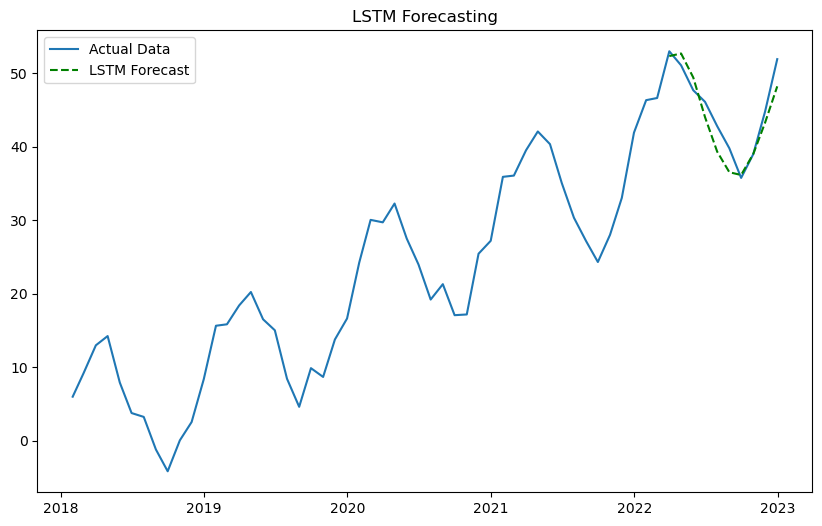

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(df, label='Actual Data')
plt.plot(lstm_forecast_df, label='LSTM Forecast',
         linestyle='dashed', color='green')
plt.title("LSTM Forecasting")
plt.legend()
plt.show()

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [121]:
def evaluate_model(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

In [123]:
sarima_test_actual = df['Value'].iloc[-len(sarima_forecast):]
evaluate_model(sarima_test_actual, sarima_forecast, "SARIMA")

SARIMA - MAE: 10.1582, RMSE: 10.2305


In [125]:
evaluate_model(df['Value'].iloc[-len(lstm_predictions):], lstm_predictions, "LSTM")

LSTM - MAE: 1.8463, RMSE: 2.2193
